# Third Assignment

##MSc course in Artificial Intelligence

insert your "Name Surname"

In [4]:
# !rm -r AI_USI_MA/
# !git clone https://github.com/UmbertoJr/AI_USI_MA.git

name: eil76
nPoints: 76
best_sol: 538.0


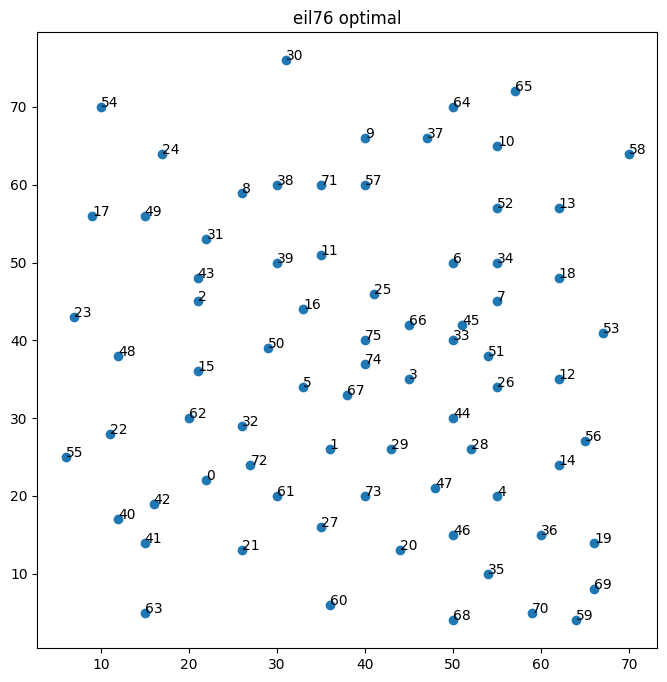

In [5]:
# Imports

#from AI_USI_MA.IO_manager.io_tsp import TSP_Instance_Creator
# if you are running from your local remove the prefix AI2020 (comment the previous line and uncomment the following line)
from AI_USI_MA.IO_manager.io_tsp import TSP_Instance_Creator

ic = TSP_Instance_Creator("standard", 'eil76.tsp')
ic.print_info()
ic.plot_data()

name: ch130
nPoints: 130
best_sol: 6110.0


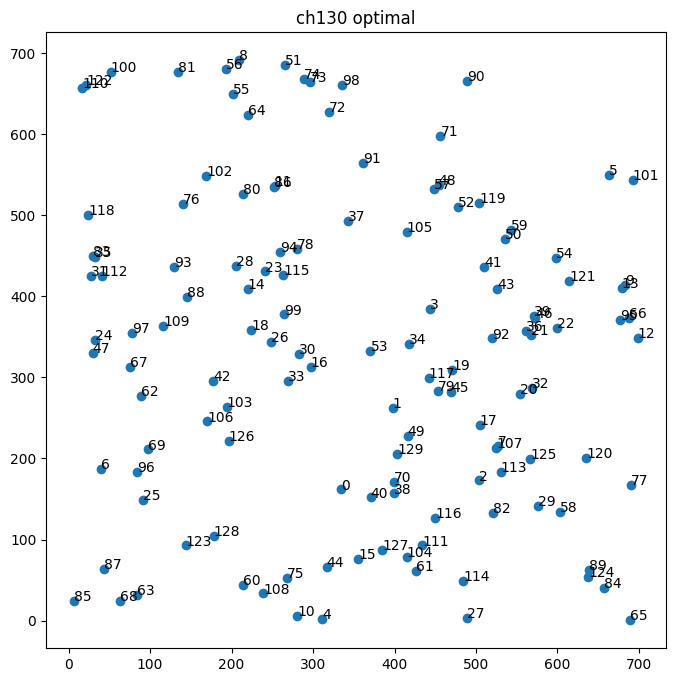

In [6]:
ic = TSP_Instance_Creator("standard", 'ch130.tsp')
ic.print_info()
ic.plot_data()

name: d198
nPoints: 198
best_sol: 15780.0


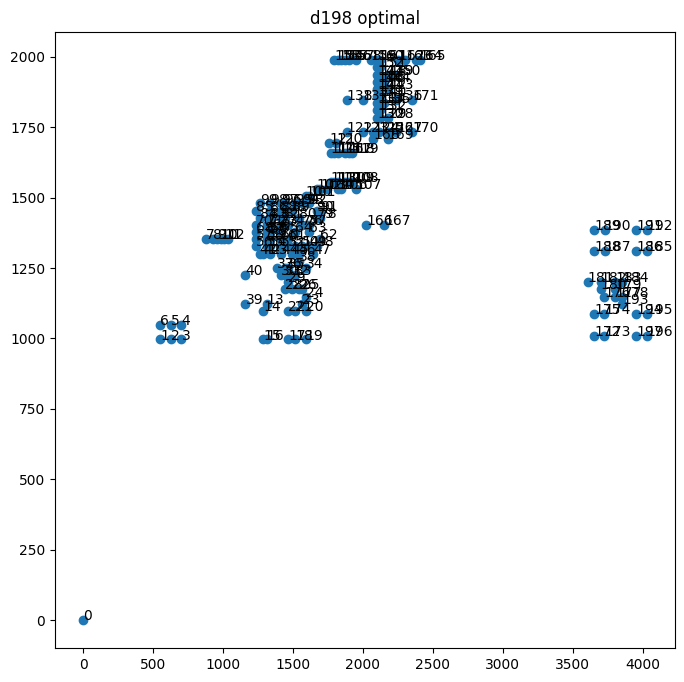

In [7]:
ic = TSP_Instance_Creator("standard", 'd198.tsp')
ic.print_info()
ic.plot_data()

name: myTSP_dim10
nPoints: 10
best_sol: 2732.0


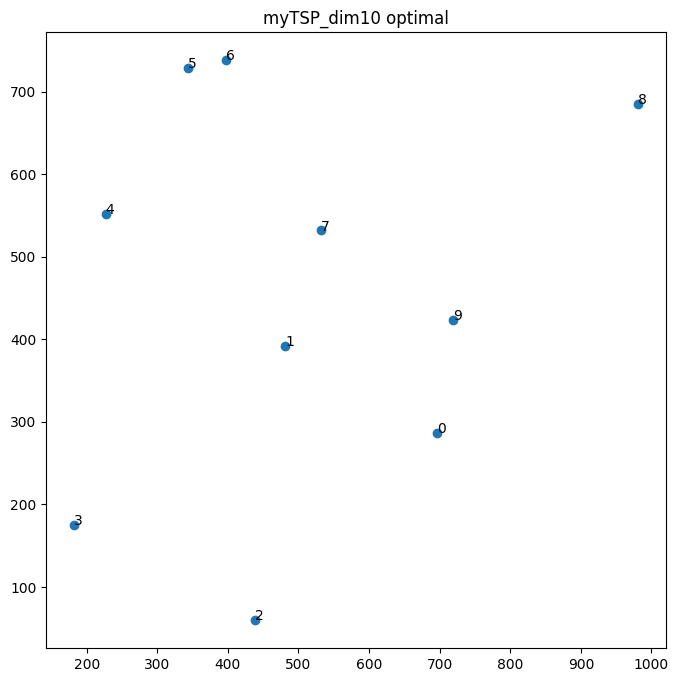

In [8]:
ic = TSP_Instance_Creator("standard", 'myTSP_dim10.tsp')
ic.print_info()
ic.plot_data()

# ACS solver class

In [9]:
import numpy as np
from AI_USI_MA.solvers.local_search import twoOpt
from AI_USI_MA.solvers.constructive_algorithms import nn
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from time import time

# nn takes as input the distance matrix and returns
# the tour and the length constructed with nearest neighbor, i.e.   tour, len_t = nn(dist_mat)

# twoOpt takes as input the solution, the actual_len and the distance matrix
# and returns the tour and the length created with 2-opt, i.e.     tour, lent_t = twoOpt(solution, actual_len, dist_mat)


class ACS:
  m = 10
  beta = 2
  alpha = rho = 0.1
  cl = 20 # or 15

  @staticmethod
  def take_candidates(j, dist_mat):
    return list(np.argsort(dist_mat[j])[1:ACS.cl+1])
  
  def read_candidate_list_from_LKH(self, ic): 
    ''' 
    This function reads the candidate list generated from the approaches available from the LKH implementation. 
    :param file_name: the name of the file containing the candidate list is of the type .cl 
    inside each file there is a first row that contains the number of nodes in the TSP from the second line up to the end (which is given by 1 and EOF) the lines gives the following informations: 
    a node number, the number of the dad of the node in the minimum spanning tree (0, if the node has no dad), the number of candidate edges emanating from the node, followed by the candidate edges. For each candidate edge its end node number and alpha-value are given. 
    :return: the candidate list saved as a dictionary were the key is the node number and the value is a list of the candidate edges 
    ''' 
    if ic.name ==  'd198': 
      file_path = "./AI_USI_MA/problems/TSP/CLs/d198.cl" 
    elif ic.name == 'ch130': 
      file_path = "./AI_USI_MA/problems/TSP/CLs/ch130.cl" 
    else:
      return {}
    candidate_list = {} 
    with open(file_path, 'r') as file: 
      num_nodes = int(file.readline().strip()) 
      for line in file: 
        line_data = list(map(int, line.strip().split())) 
        if line_data[0] == -1: 
          break
        node_number = line_data[0]
        num_candidate_edges = line_data[2] 
        # Extract candidate edges information (end node number, alpha-value) 
        # candidate_edges = [(int(line_data[i])-1, line_data[i + 1]) for i in range(3, 2*num_candidate_edges + 3, 2)] 
        # Extract candidate edges information (end node number) 
        candidate_edges = [int(line_data[i]) - 1 for i in range(3, 2 * num_candidate_edges + 3, 2)] 
 
        candidate_list[int(node_number)-1] = candidate_edges 
 
    return candidate_list
    

  def __init__(self, instance, candidate=True, q=0.98):
    self.candidate = candidate
    self.best_length = float('inf')
    self.q0 = q
    self.alpha = self.rho = 0.1
    self.beta = 2
    self.m = 10
    self.current_best_length = float('inf')
    self.current_best_tour = []
    #self.cl = 20
    self.n = instance.nPoints
    self.dist_mat = instance.dist_matrix
    _, self.L_nn = nn(instance.dist_matrix, starting_node=np.random.choice(self.n))
    self.tau0 = 1./(float(self.n) * self.L_nn)
    self.position = {i: None for i in range(ACS.m)}  # position collector for the Ants, TO BE UPDATED during the steps
    self.tour = {i: [] for i in range(ACS.m)}  # tour collector for the Ants
    self.candidate_list = self.read_candidate_list_from_LKH(instance) if self.candidate else {}
    # if the candidate list is empty
    if ic.name not in ['d198', 'ch130']:
      self.candidate = False
    self.to_be_visited = [list(range(self.n)) for _ in range(self.m)]
    self.eta = {}
    #if self.candidate:
    #  self.pheromone = {r: [self.tau0]*len(self.candidate_list[r]) for r in range(self.n)}
    #else:
    self.pheromone = {r: [self.tau0]*self.n for r in range(self.n)}
    self.eta = {r: [1/self.dist_mat[r, s] if r!=s else 0 for s in range(self.n)] for r in range(self.n)}
      
    
  def state_transition(self, k):
    r = self.position[k]
    
    list_ = []
    if self.candidate and len(self.candidate_list[r]) > 1:
      for u in self.candidate_list[r]:
        if u in self.to_be_visited[k]:
          list_.append(u)
      if len(list_) == 0:
        list_ = self.to_be_visited[k]
    else:
      list_ = self.to_be_visited[k]
    if len(list_) == 1:
      s = list_[0]
      return s
    q = np.random.uniform(0, 1)
    if q < self.q0:
      self.pheromone[r]
      self.eta[r]
      i=0
      s=0
      try:
        # Find the index of the maximum value of the product of the pheromone and the heuristic information
        i = np.argmax([self.pheromone[r][u]*self.eta[r][u]**self.beta for u in list_])
        # Return the nocorrespondingde  to the index
        s = list_[i]
      except Exception as e:
        print("r: ", r)
        print("list: ", list_)
        print("len list: ", len(list_))
        print("pheromone[r]: ", self.pheromone[r])
        print("eta[r]: ", self.eta[r])
        for u in list_:
          print("r: ", r)
          print("u: ", u)
          print("pheromone[r][u]: ", self.pheromone[r][u])
          print("eta[r][u]: ", self.eta[r][u])
        raise e
    else:
      try:
        x = sum([self.pheromone[r][u]*self.eta[r][u]**self.beta for u in list_])
        p = [self.pheromone[r][u]*self.eta[r][u]**self.beta for u in list_]/x if x != 0 else [1/len(list_)]
        s = np.random.choice(list_, p=p, size=1)[0]
      except Exception as e:
        print("r: ", r)
        print("list: ", list_)
        print("len list: ", len(list_))
        print("pheromone[r]: ", self.pheromone[r])
        print("eta[r]: ", self.eta[r])
        for u in list_:
          print("r: ", r)
          print("u: ", u)
          print("pheromone[r][u]: ", self.pheromone[r][u])
          print("eta[r][u]: ", self.eta[r][u])
        raise e
    return s

  def local_updating(self, r, s):
    self.pheromone[r][s] = (1-self.rho)*self.pheromone[r][s] + self.rho*self.tau0
    self.pheromone[s][r] = (1-self.rho)*self.pheromone[s][r] + self.rho*self.tau0
    
    
  '''
  For the global update, we have two options:
  1) Update the pheromone of the edges in the best tour every time an ant pass by an
  edge in the best tour
  2) Update the pheromone of the edges in the best tour just once, even if no ants pass by
  the edges in the best tour
  I implemented both of them, but the first one seems to work really better
  '''
    
  def global_update(self, best_tour, best_len):
    
    # Update the pheromone of the edges in the best tour every time an ant pass by an
    # edge in the best tour
    
    for k in range(self.m):
      for i,r in enumerate(self.tour[k]):
        # If edge (r,s) is in the best tour, increase its pheromone
        s = self.tour[k][(i+1)%len(self.tour[k])]
        if best_tour.index(r) == best_tour.index(s) + 1 or best_tour.index(r) == best_tour.index(s) - 1:
          self.pheromone[r][s] = (1-self.alpha)*self.pheromone[r][s] + self.alpha/best_len
        else:
          self.pheromone[r][s] = (1-self.alpha)*self.pheromone[r][s]
        # symmetric
        self.pheromone[s][r] = self.pheromone[r][s]
        
    # Update the pheromone of the edges in the best tour just once, even if no ants pass by
    # the edges in the best tour
        
    '''
    for r in range(self.n):
      for s in range(self.n):
        self.pheromone[r][s] = (1-self.alpha)*self.pheromone[r][s]
        self.pheromone[s][r] = self.pheromone[r][s]
    for i in range(len(best_tour)):
      r = best_tour[i]
      s = best_tour[(i+1)%len(best_tour)]
      self.pheromone[r][s] += self.alpha/best_len
      self.pheromone[s][r] = self.pheromone[r][s]
    '''
      
  def iteration(self, optimization):
    # initialization
    nodes = list(range(self.n))
    self.to_be_visited = [list(range(self.n)) for _ in range(self.m)]
    self.tour = {i: [] for i in range(ACS.m)}
    for k in range(self.m):
      self.position[k] = np.random.choice(nodes)
      nodes.remove(self.position[k])
      self.tour[k].append(self.position[k])
      self.to_be_visited[k].remove(self.position[k])
    
    # Tour construction
    for i in range(self.n-1): # to so in range(self.n)
      for k in range(self.m):
        s = self.state_transition(k)
        self.to_be_visited[k].remove(s)
        self.tour[k].append(s)
        self.local_updating(self.position[k], s) # update the pheromone of the edges in the tour
        self.position[k] = s
        
        
    # go back to the starting node    
    for r in range(self.m):
      #self.tour[r].append(self.tour[r][0])
      self.position[r] = self.tour[r][0]
    
    # local updating
    for r in range(self.m):
      for i,s in enumerate(self.tour[r]):
        self.local_updating(s, self.tour[r][(i+1)%len(self.tour[r])]) # update the pheromone of the edges in the tour
    
    # computing length of the tours
    #lenghts = {r: sum([self.dist_mat[self.tour[r][i], self.tour[r][i+1]] for i in range(len(self.tour[r])-1)]) for r in range(self.m)} # to do range(len(self.tour[r])
    lenghts = []
    for k in range(self.m):
      lenghts.append(sum([self.dist_mat[self.tour[k][i], self.tour[k][i+1]] for i in range(len(self.tour[k])-1)]) + self.dist_mat[self.tour[k][0], self.tour[k][-1]])
    self.best_ant = np.argmin(lenghts)
    self.current_best_length = min(lenghts)
    self.current_best_tour = self.tour[self.best_ant]
    if self.current_best_length < self.best_length:
      self.best_length = self.current_best_length
      self.best_tour = self.current_best_tour
    
    if (optimization):
        new_tour, new_length = twoOpt(self.current_best_tour, self.current_best_length, self.dist_mat)
        new_tour = new_tour.tolist()
        if new_length < self.best_length:
          self.best_tour, self.best_length = new_tour, new_length
    
    self.global_update(self.best_tour, self.best_length)
  
    
  def solve(self, ic, max_iter=100, optimization=True):
    start = time()
    results = []
    tours = []
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_title("Your Title")
    for i in range(max_iter):
      if time()-start > 180:
        break
      self.iteration(optimization)
      results.append(self.current_best_length)
      tours.append(self.current_best_tour)
      
      # COMMENT THE FOLLOWING LINE IF YOU DO NOT WANT TO SEE THE ANIMATION #####
      ic.plot_solution(self.best_tour, ax, fig, (str(i) +" Length: "+str(self.best_length)), pause_time=0.001, interm_results=True)
        
    #ic.plot_solution(self.best_tour, ax, fig, i, pause_time=0.01, interm_results=False)
    ic.plot_solution(self.best_tour, ax, fig, (str((i+1)*10) +(" 2opt: " if optimization else " non-opt:")+str(self.best_length)), pause_time=0.001, interm_results=False)
    return tours, results
      

# Main loop with q0 = 0.98
## Skip this cell for the loop with every q0 value

KeyboardInterrupt: 

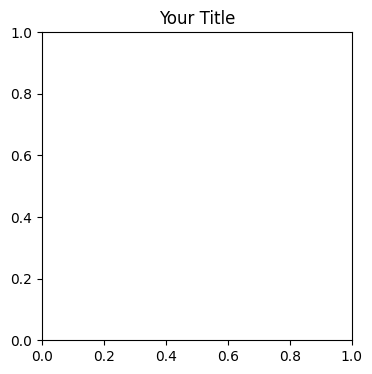

In [10]:
import random
rel_errors = []
rel_errors2 = []
rel_errors3 = []
best_lengths = []
best_lengths2 = []
best_lengths3 = []
hist = [] # [[], [], []] # for each instance, results of the basic algorithm
hist2opt = []
hist3opt = []
n_tours = []
rows = []
gap = []
gap2 = []
gap3 = []
# For each TSP instance
problems = ['eil76', 'ch130', 'd198']
for instance in problems:
    random.seed(0)
    ic = TSP_Instance_Creator("standard", instance + '.tsp')
    
    iterations = 100000
    
    # Basic
    acs = ACS(ic, candidate=False)
    start = time()
    tours, results = acs.solve(ic, iterations, optimization=False)
    time1 = time()-start
    hist.append(results)
    best_length = min(results)
    best_tour = tours[np.argmin(results)]
    rel_error = (best_length - ic.best_sol) / ic.best_sol * 100
    print(f"Best tour length: {best_length}")
    print("Relative error basic: ", rel_error, "%")
    
    
    
    # 2-opt
    acs2 = ACS(ic, candidate=False)
    start = time()
    tours2opt, results2opt = acs2.solve(ic, iterations, optimization=True)
    time2 = time()-start
    hist2opt.append(results2opt)
    best_length2 = min(results2opt)
    best_tour2 = tours2opt[np.argmin(results2opt)]
    rel_error2 = (best_length2 - ic.best_sol) / ic.best_sol * 100
    print(f"Best tour length: {best_length2}")
    print("Relative error 2-opt: ", rel_error2, "%")
    
    
    # 2-opt with candidate list
    acs3 = ACS(ic, candidate=True)
    start = time()
    tours3opt, results3opt = acs3.solve(ic, iterations, optimization=True)
    time3 = time()-start
    hist3opt.append(results3opt)
    best_length3 = min(results3opt)
    best_tour3 = tours3opt[np.argmin(results3opt)]
    rel_error3 = (best_length3 - ic.best_sol) / ic.best_sol * 100
    print(f"Best tour length: {best_length3}")
    print("Relative error 2-opt + candidate: ", rel_error3, "%")
    
    
    rel_errors.append(rel_error)
    rel_errors2.append(rel_error2)
    rel_errors3.append(rel_error3)
    best_lengths.append(best_length)
    best_lengths2.append(best_length2)
    best_lengths3.append(best_length3)
    
    gap = [(results[i] - ic.best_sol)/ic.best_sol*100 for i in range(len(results))]
    gap2 = [(results2opt[i] - ic.best_sol)/ic.best_sol*100 for i in range(len(results2opt))]
    gap3 = [(results3opt[i] - ic.best_sol)/ic.best_sol*100 for i in range(len(results3opt))]
    
    # Create rows for the table
    rows.append([instance, 0, best_length, acs.m*iterations, np.mean(results), np.std(results), ic.best_sol, rel_error, np.mean(gap), time1])
    rows.append([instance, 0, best_length2, acs2.m*iterations, np.mean(results2opt), np.std(results2opt), ic.best_sol, rel_error2, np.mean(gap2), time2])
    rows.append([instance, 0, best_length3, acs3.m*iterations, np.mean(results3opt), np.std(results3opt), ic.best_sol, rel_error3, np.mean(gap3), time3])
# Tabulate
import tabulate
columns = ["Instance", "Seed", "Best Length", "Tours Number",
           "Avg Length", "Std Dev", "Opt Sol",
           "Relative Error (%)", "Avg Best Gap", "Execution Time"]



In [13]:
from tabulate import tabulate
print(tabulate(rows, headers=columns, tablefmt="pretty"))

# Useless since it is always 3 minutes
# Print mean and standard deviation of execution times
#print(f"mean time {np.mean(list_time)}, std time {np.std(list_time)}")

+----------+------+-------------+--------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+
| Instance | Seed | Best Length | Tours Number |     Avg Length     |      Std Dev       | Opt Sol | Relative Error (%) |    Avg Best Gap    |   Execution Time   |
+----------+------+-------------+--------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+
|  eil76   |  0   |    546.0    |   1000000    | 549.1138962870124  | 11.287160829569363 |  538.0  | 1.486988847583643  | 2.0657799789985827 |  180.317400932312  |
|  eil76   |  0   |    549.0    |   1000000    | 549.9645882912898  | 1.5624955583178322 |  538.0  | 2.0446096654275094 | 2.2239011693847326 | 180.36348295211792 |
|  eil76   |  0   |    548.0    |   1000000    | 554.9672197083962  | 3.9040698057615653 |  538.0  | 1.858736059479554  | 3.1537583101108146 | 180.3243682384491  |
|  ch130   |  0 

Relative errors:  [1.486988847583643, 2.3731587561374794, 2.6045627376425853]
Relative errors 2opt:  [2.0446096654275094, 1.0310965630114566, 1.4828897338403042]
Relative errors 2opt + candidate:  [1.858736059479554, 1.8494271685761048, 0.6083650190114068]
Best lengths:  [546.0, 6255.0, 16191.0]
Best lengths 2opt:  [549.0, 6173.0, 16014.0]
Best lengths 2opt + candidate:  [548.0, 6223.0, 15876.0]


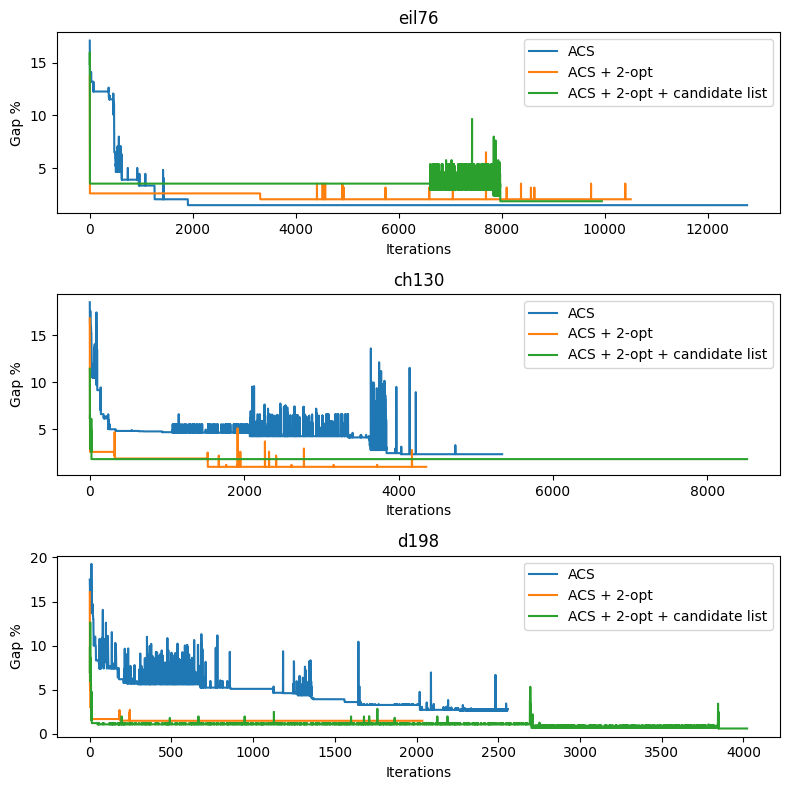

In [15]:
print("Relative errors: ", rel_errors)
print("Relative errors 2opt: ", rel_errors2)
print("Relative errors 2opt + candidate: ", rel_errors3)
print("Best lengths: ", best_lengths)
print("Best lengths 2opt: ", best_lengths2)
print("Best lengths 2opt + candidate: ", best_lengths3)
#print("Optimal solutions: ", opt_solutions)
# Plot the results in one figure

# For each problem instance: A plot showing the average of the three runs and the
# best gap achieved for each run, with the gap on the y-axis and iteration number on
# the x-axis.

fig, ax = plt.subplots(3, figsize=(8, 8))
for i, name in enumerate(problems):
    ic = TSP_Instance_Creator("standard", name + '.tsp')
    ax[i].set_title(name)
    ax[i].set_xlabel('Iterations')
    ax[i].set_ylabel('Gap %')
    ax[i].plot(((hist[i]-np.repeat(ic.best_sol, len(hist[i])))/ic.best_sol*100), label='ACS')
    ax[i].plot(((hist2opt[i]-np.repeat(ic.best_sol, len(hist2opt[i])))/ic.best_sol*100), label='ACS + 2-opt')
    ax[i].plot(((hist3opt[i]-np.repeat(ic.best_sol, len(hist3opt[i])))/ic.best_sol*100), label='ACS + 2-opt + candidate list')
    ax[i].legend()
plt.tight_layout()
plt.show()

%store -r


# Loop with q0 = [0.98, 0.5, 1-13/n]

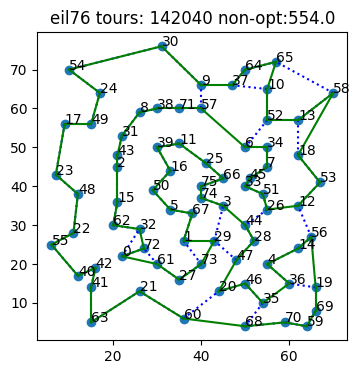

Best tour length: 554.0
Relative error basic:  2.973977695167286 %


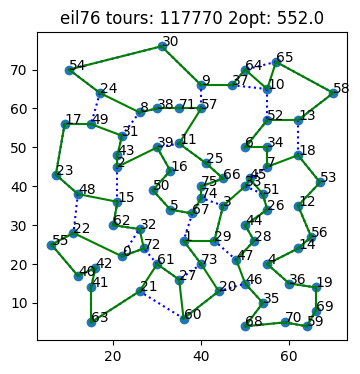

Best tour length: 552.0
Relative error 2-opt:  2.6022304832713754 %


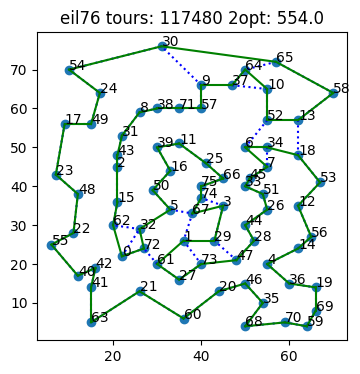

Best tour length: 554.0
Relative error 2-opt + candidate:  2.973977695167286 %


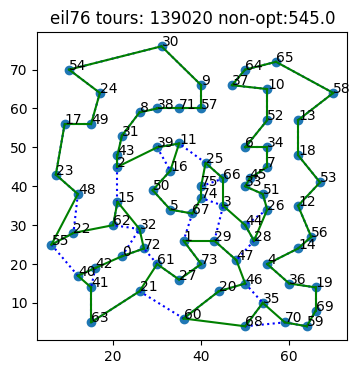

Best tour length: 545.0
Relative error basic:  1.3011152416356877 %


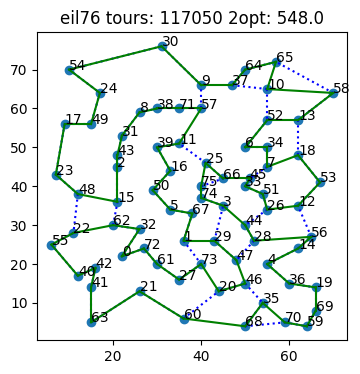

Best tour length: 548.0
Relative error 2-opt:  1.858736059479554 %


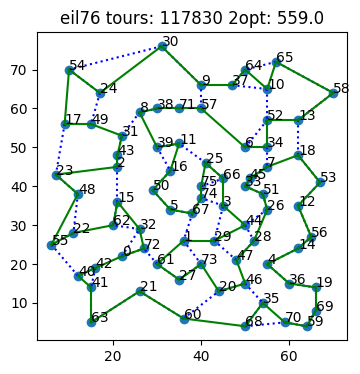

Best tour length: 559.0
Relative error 2-opt + candidate:  3.903345724907063 %


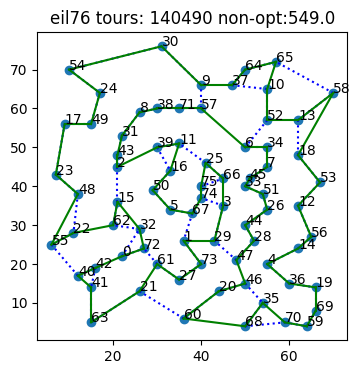

Best tour length: 549.0
Relative error basic:  2.0446096654275094 %


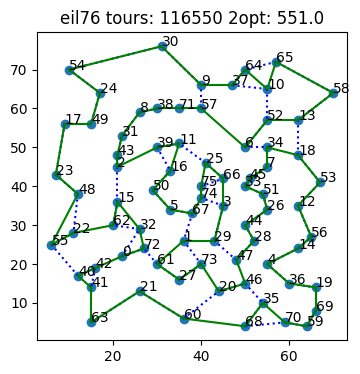

Best tour length: 551.0
Relative error 2-opt:  2.41635687732342 %


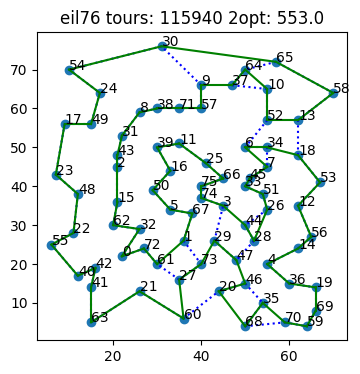

Best tour length: 553.0
Relative error 2-opt + candidate:  2.7881040892193307 %


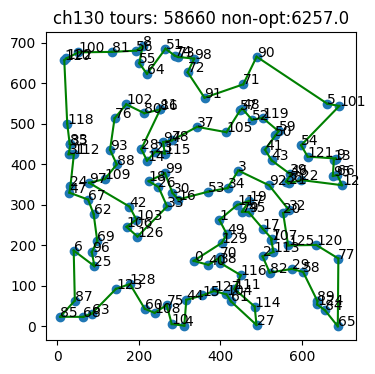

Best tour length: 6257.0
Relative error basic:  2.4058919803600656 %


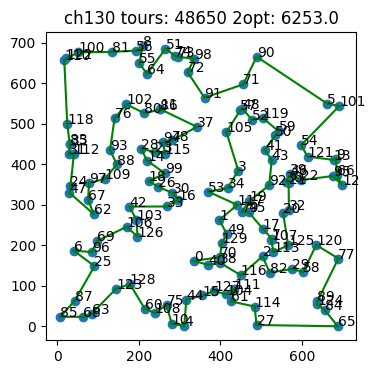

Best tour length: 6253.0
Relative error 2-opt:  2.3404255319148937 %


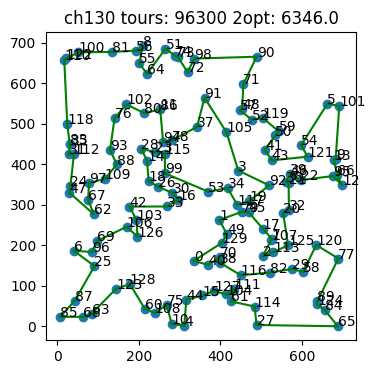

Best tour length: 6346.0
Relative error 2-opt + candidate:  3.8625204582651387 %


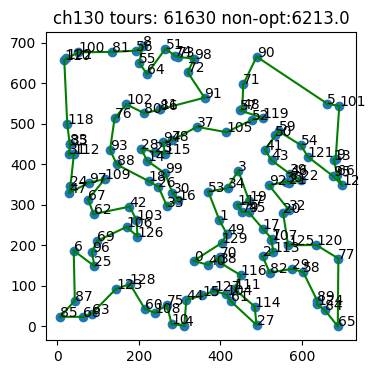

Best tour length: 6213.0
Relative error basic:  1.6857610474631752 %


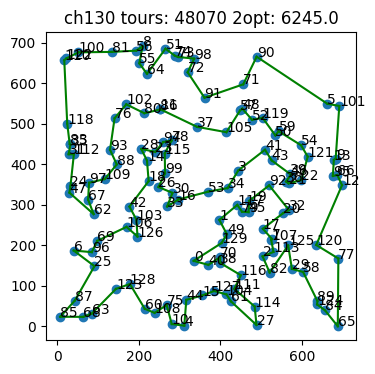

Best tour length: 6245.0
Relative error 2-opt:  2.20949263502455 %


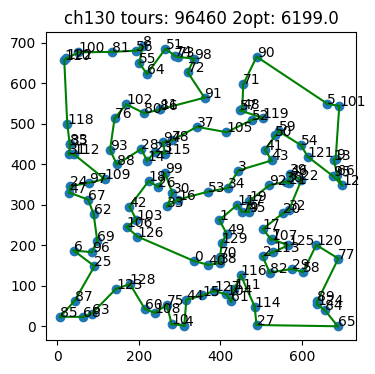

Best tour length: 6199.0
Relative error 2-opt + candidate:  1.4566284779050735 %


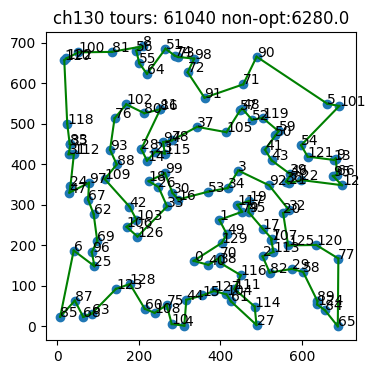

Best tour length: 6280.0
Relative error basic:  2.7823240589198037 %


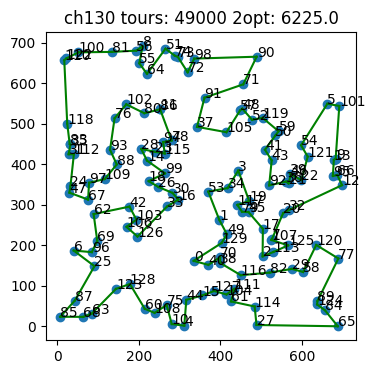

Best tour length: 6225.0
Relative error 2-opt:  1.8821603927986905 %


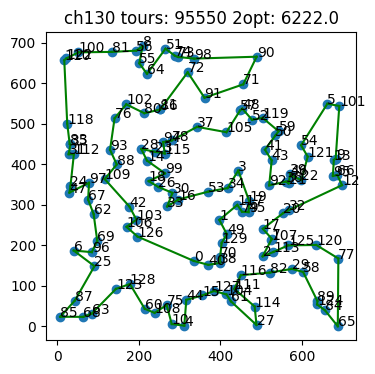

Best tour length: 6222.0
Relative error 2-opt + candidate:  1.8330605564648117 %


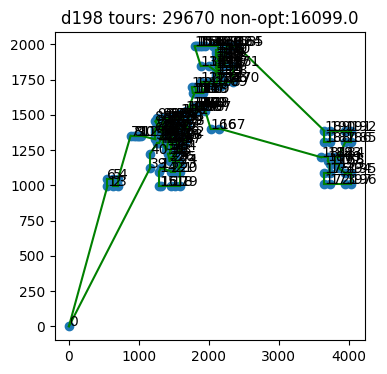

Best tour length: 16099.0
Relative error basic:  2.0215462610899873 %


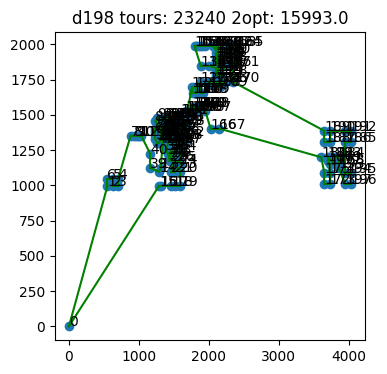

Best tour length: 15993.0
Relative error 2-opt:  1.3498098859315588 %


C:\Users\matti\AppData\Local\Temp\ipykernel_16516\869071828.py:245: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(4, 4))


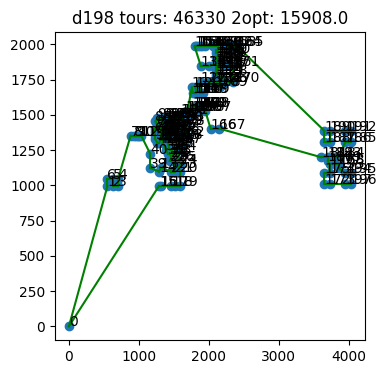

Best tour length: 15908.0
Relative error 2-opt + candidate:  0.8111533586818758 %


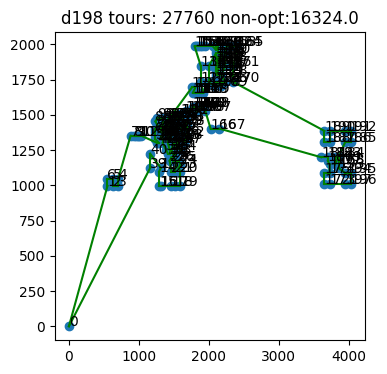

Best tour length: 16324.0
Relative error basic:  3.447401774397972 %


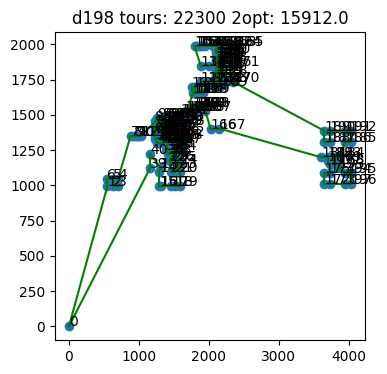

Best tour length: 15912.0
Relative error 2-opt:  0.8365019011406843 %


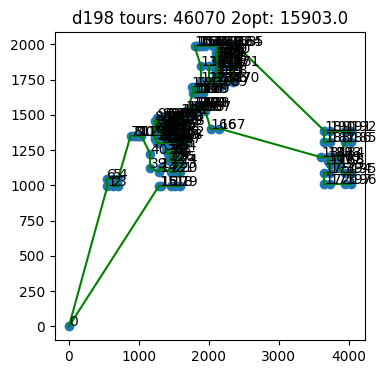

Best tour length: 15903.0
Relative error 2-opt + candidate:  0.779467680608365 %


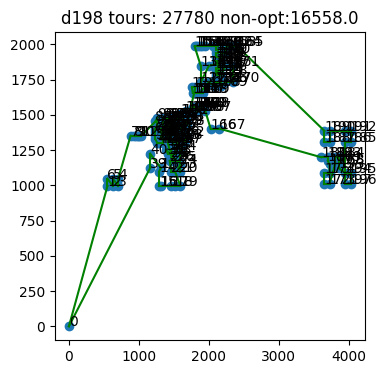

Best tour length: 16558.0
Relative error basic:  4.930291508238276 %


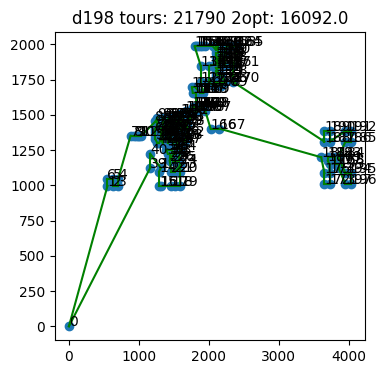

Best tour length: 16092.0
Relative error 2-opt:  1.977186311787072 %


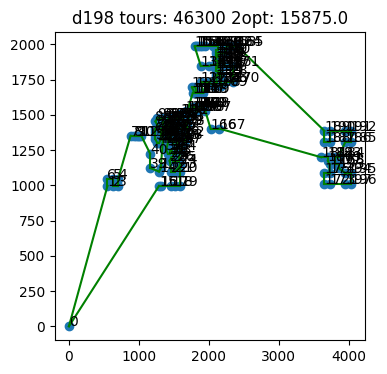

Best tour length: 15875.0
Relative error 2-opt + candidate:  0.6020278833967047 %


NameError: name 'tabulate' is not defined

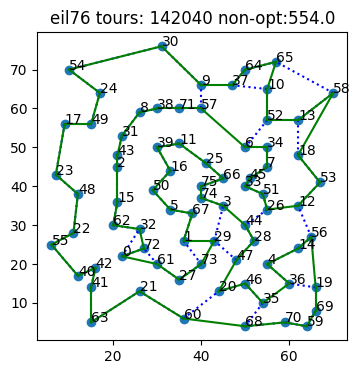

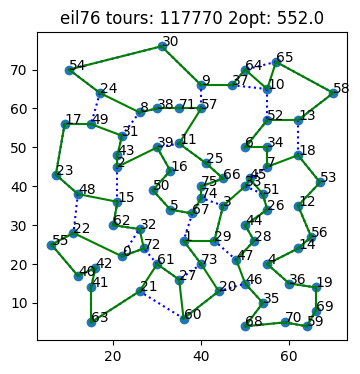

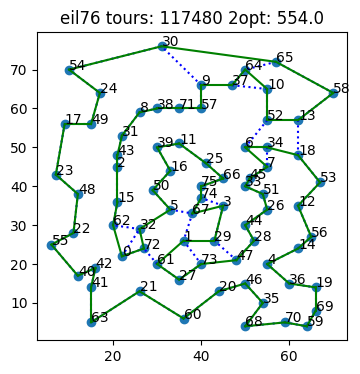

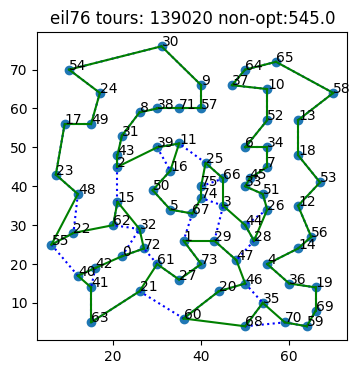

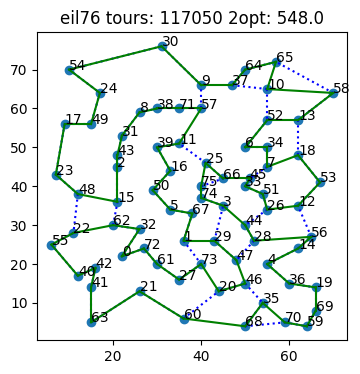

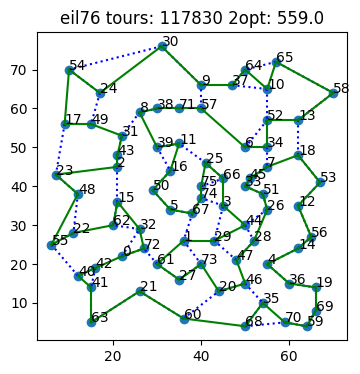

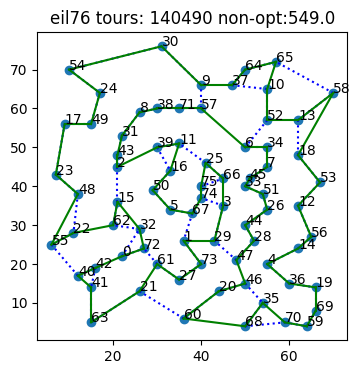

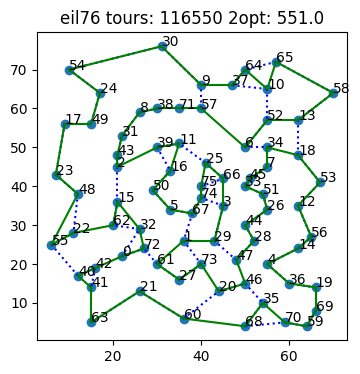

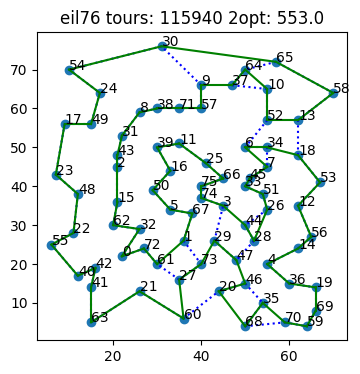

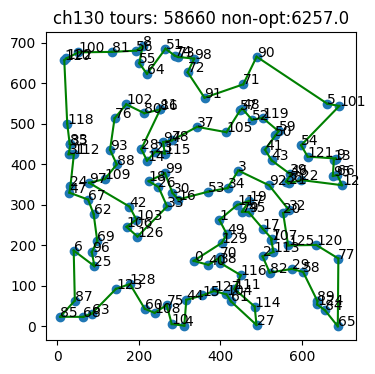

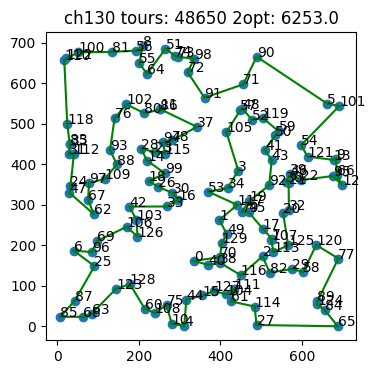

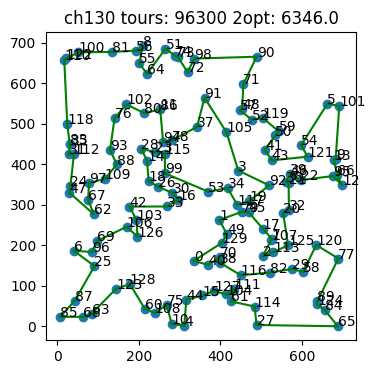

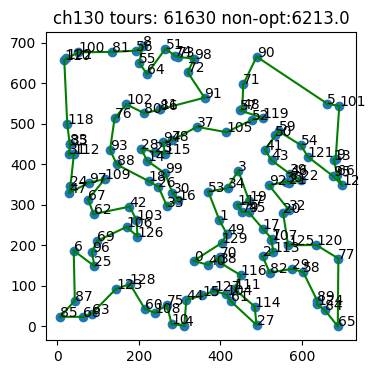

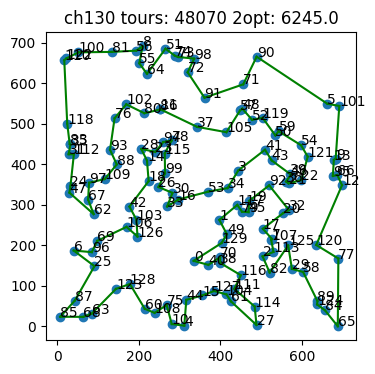

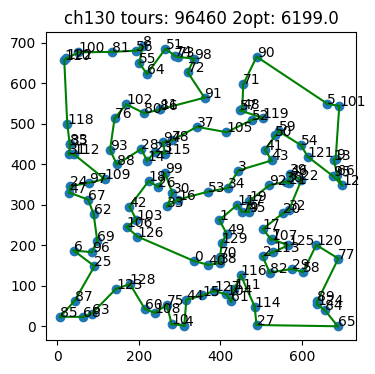

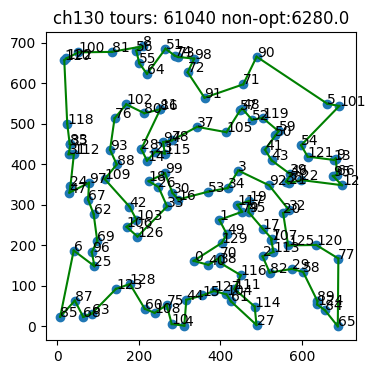

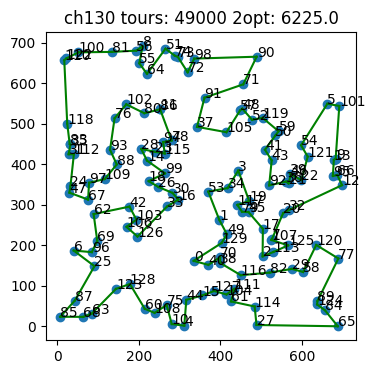

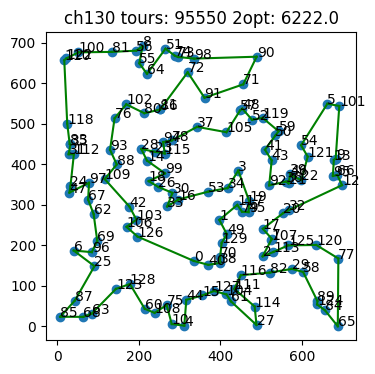

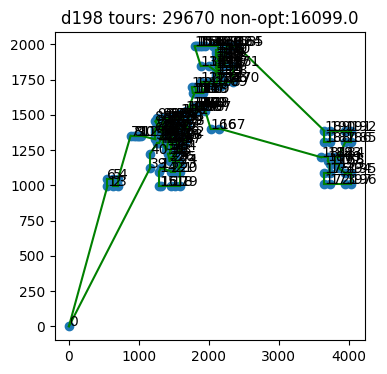

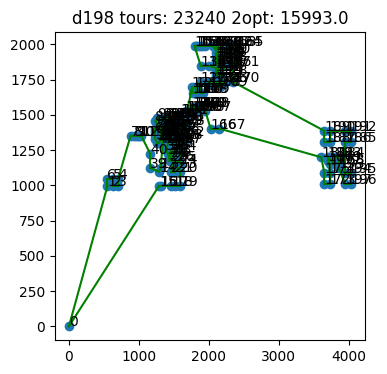

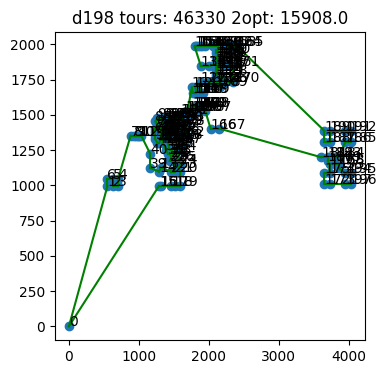

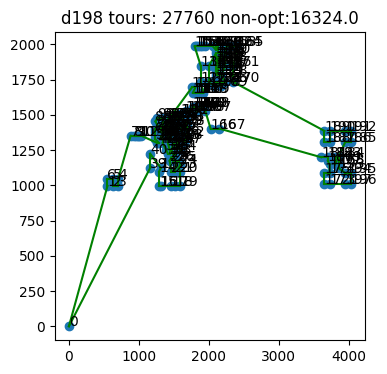

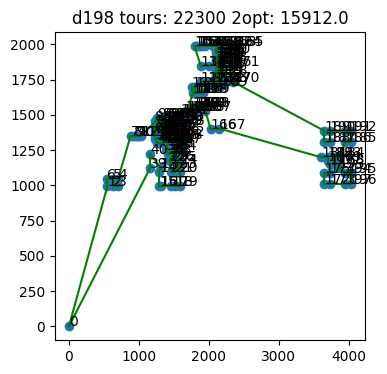

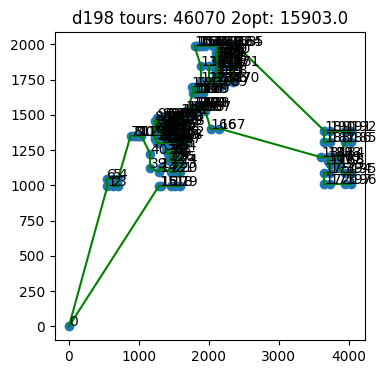

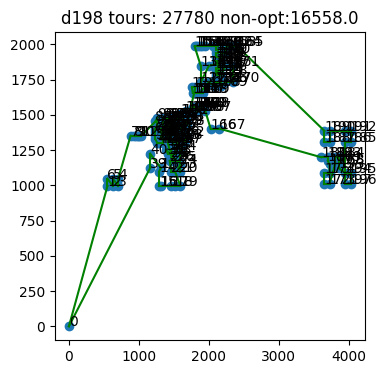

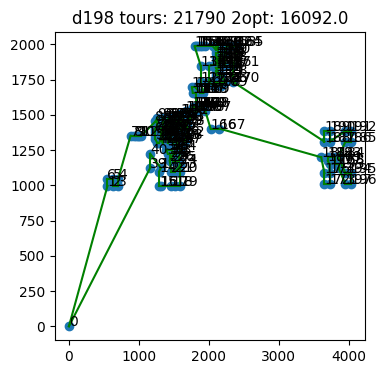

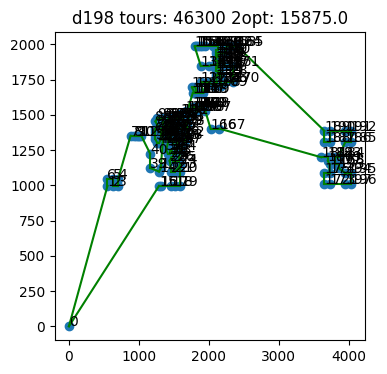

In [11]:
# Here i try to solve with q = 0.5 and q = 1-13/n, but just with the 2-opt candidate list acs
# For each TSP instance
import random
from tabulate import tabulate
import numpy as np

rel_errors = []
rel_errors2 = []
rel_errors3 = []
best_lengths = []
best_lengths2 = []
best_lengths3 = []
hist = [] # [ [q1-eil] , [q2-eil], [q1-ch130], [...] ] # for each q, for each instance, results of the basic algorithm
hist2opt = [] # [ [q1-eil] , [q2-eil], [q1-ch130], [...] ] # for each q, for each instance, results of the 2opt algorithm
hist3opt = [] # [ [q1-eil] , [q2-eil], [q1-ch130], [...] ] # for each q, for each instance, results of the 2opt + cl algorithm
n_tours = []
rows = []
gap = []
gap2 = []
gap3 = []
gaps = []
gaps2 = []
gaps3 = []
# For each TSP instance
problems = ['eil76', 'ch130', 'd198']
for instance in problems:
    qs = [0.98, 0.5, 1-13/ic.nPoints]
    for q in qs:
        random.seed(0)
        ic = TSP_Instance_Creator("standard", instance + '.tsp')
        
        iterations = 100000
        
        # Basic
        acs = ACS(ic, candidate=False)
        start = time()
        tours, results = acs.solve(ic, iterations, optimization=False)
        time1 = time()-start
        hist.append(results)
        best_length = min(results)
        best_tour = tours[np.argmin(results)]
        rel_error = (best_length - ic.best_sol) / ic.best_sol * 100
        print(f"Best tour length: {best_length}")
        print("Relative error basic: ", rel_error, "%")
        
        
        
        # 2-opt
        acs2 = ACS(ic, candidate=False)
        start = time()
        tours2opt, results2opt = acs2.solve(ic, iterations, optimization=True)
        time2 = time()-start
        hist2opt.append(results2opt)
        best_length2 = min(results2opt)
        best_tour2 = tours2opt[np.argmin(results2opt)]
        rel_error2 = (best_length2 - ic.best_sol) / ic.best_sol * 100
        print(f"Best tour length: {best_length2}")
        print("Relative error 2-opt: ", rel_error2, "%")
        
        
        # 2-opt with candidate list
        acs3 = ACS(ic, candidate=True)
        start = time()
        tours3opt, results3opt = acs3.solve(ic, iterations, optimization=True)
        time3 = time()-start
        hist3opt.append(results3opt)
        best_length3 = min(results3opt)
        best_tour3 = tours3opt[np.argmin(results3opt)]
        rel_error3 = (best_length3 - ic.best_sol) / ic.best_sol * 100
        print(f"Best tour length: {best_length3}")
        print("Relative error 2-opt + candidate: ", rel_error3, "%")
        
        
        rel_errors.append(rel_error)
        rel_errors2.append(rel_error2)
        rel_errors3.append(rel_error3)
        best_lengths.append(best_length)
        best_lengths2.append(best_length2)
        best_lengths3.append(best_length3)
        
        gap = [(results[i] - ic.best_sol)/ic.best_sol*100 for i in range(len(results))]
        gap2 = [(results2opt[i] - ic.best_sol)/ic.best_sol*100 for i in range(len(results2opt))]
        gap3 = [(results3opt[i] - ic.best_sol)/ic.best_sol*100 for i in range(len(results3opt))]
        
        gaps.append(gap)
        gaps2.append(gap2)
        gaps3.append(gap3)
        
        # Create rows for the table
        rows.append([instance, 0, q, best_length, acs.m*iterations, np.mean(results), np.std(results), ic.best_sol, rel_error, np.mean(gap), time1])
        rows.append([instance, 0, q, best_length2, acs2.m*iterations, np.mean(results2opt), np.std(results2opt), ic.best_sol, rel_error2, np.mean(gap2), time2])
        rows.append([instance, 0, q, best_length3, acs3.m*iterations, np.mean(results3opt), np.std(results3opt), ic.best_sol, rel_error3, np.mean(gap3), time3])
    
columns = ["Instance", "Seed", "q0", "Best Length", "Tours Number",
            "Avg Length", "Std Dev", "Opt Sol",
            "Relative Error (%)", "Avg Best Gap", "Execution Time"]
print(tabulate(rows, headers=columns, tablefmt="pretty"))

%store -z

Relative errors:  [2.973977695167286, 1.3011152416356877, 2.0446096654275094, 2.4058919803600656, 1.6857610474631752, 2.7823240589198037, 2.0215462610899873, 3.447401774397972, 4.930291508238276]
Relative errors 2opt:  [2.6022304832713754, 1.858736059479554, 2.41635687732342, 2.3404255319148937, 2.20949263502455, 1.8821603927986905, 1.3498098859315588, 0.8365019011406843, 1.977186311787072]
Relative errors 2opt + candidate:  [2.973977695167286, 3.903345724907063, 2.7881040892193307, 3.8625204582651387, 1.4566284779050735, 1.8330605564648117, 0.8111533586818758, 0.779467680608365, 0.6020278833967047]
Best lengths:  [554.0, 545.0, 549.0, 6257.0, 6213.0, 6280.0, 16099.0, 16324.0, 16558.0]
Best lengths 2opt:  [552.0, 548.0, 551.0, 6253.0, 6245.0, 6225.0, 15993.0, 15912.0, 16092.0]
Best lengths 2opt + candidate:  [554.0, 559.0, 553.0, 6346.0, 6199.0, 6222.0, 15908.0, 15903.0, 15875.0]


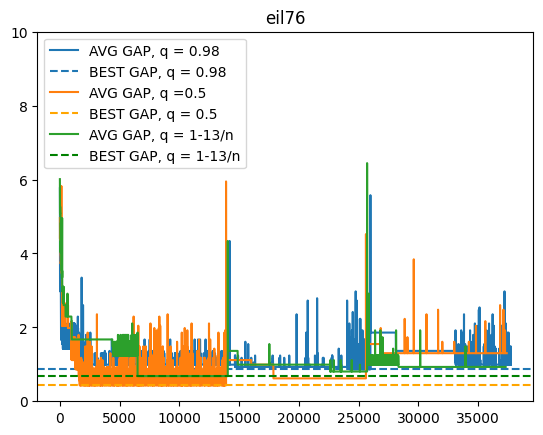

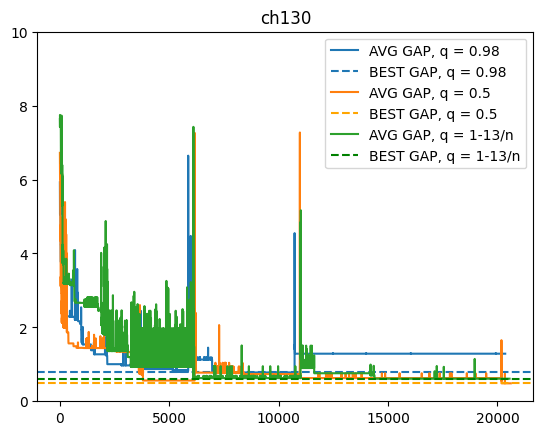

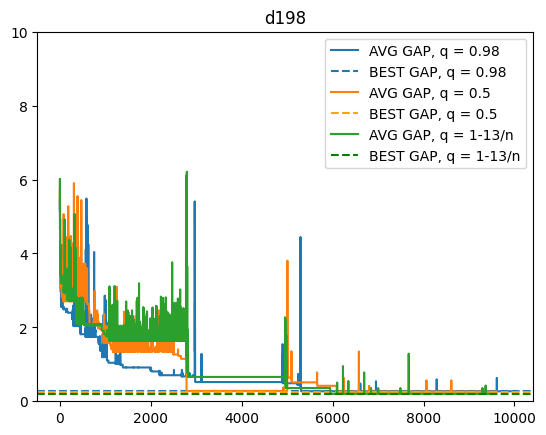

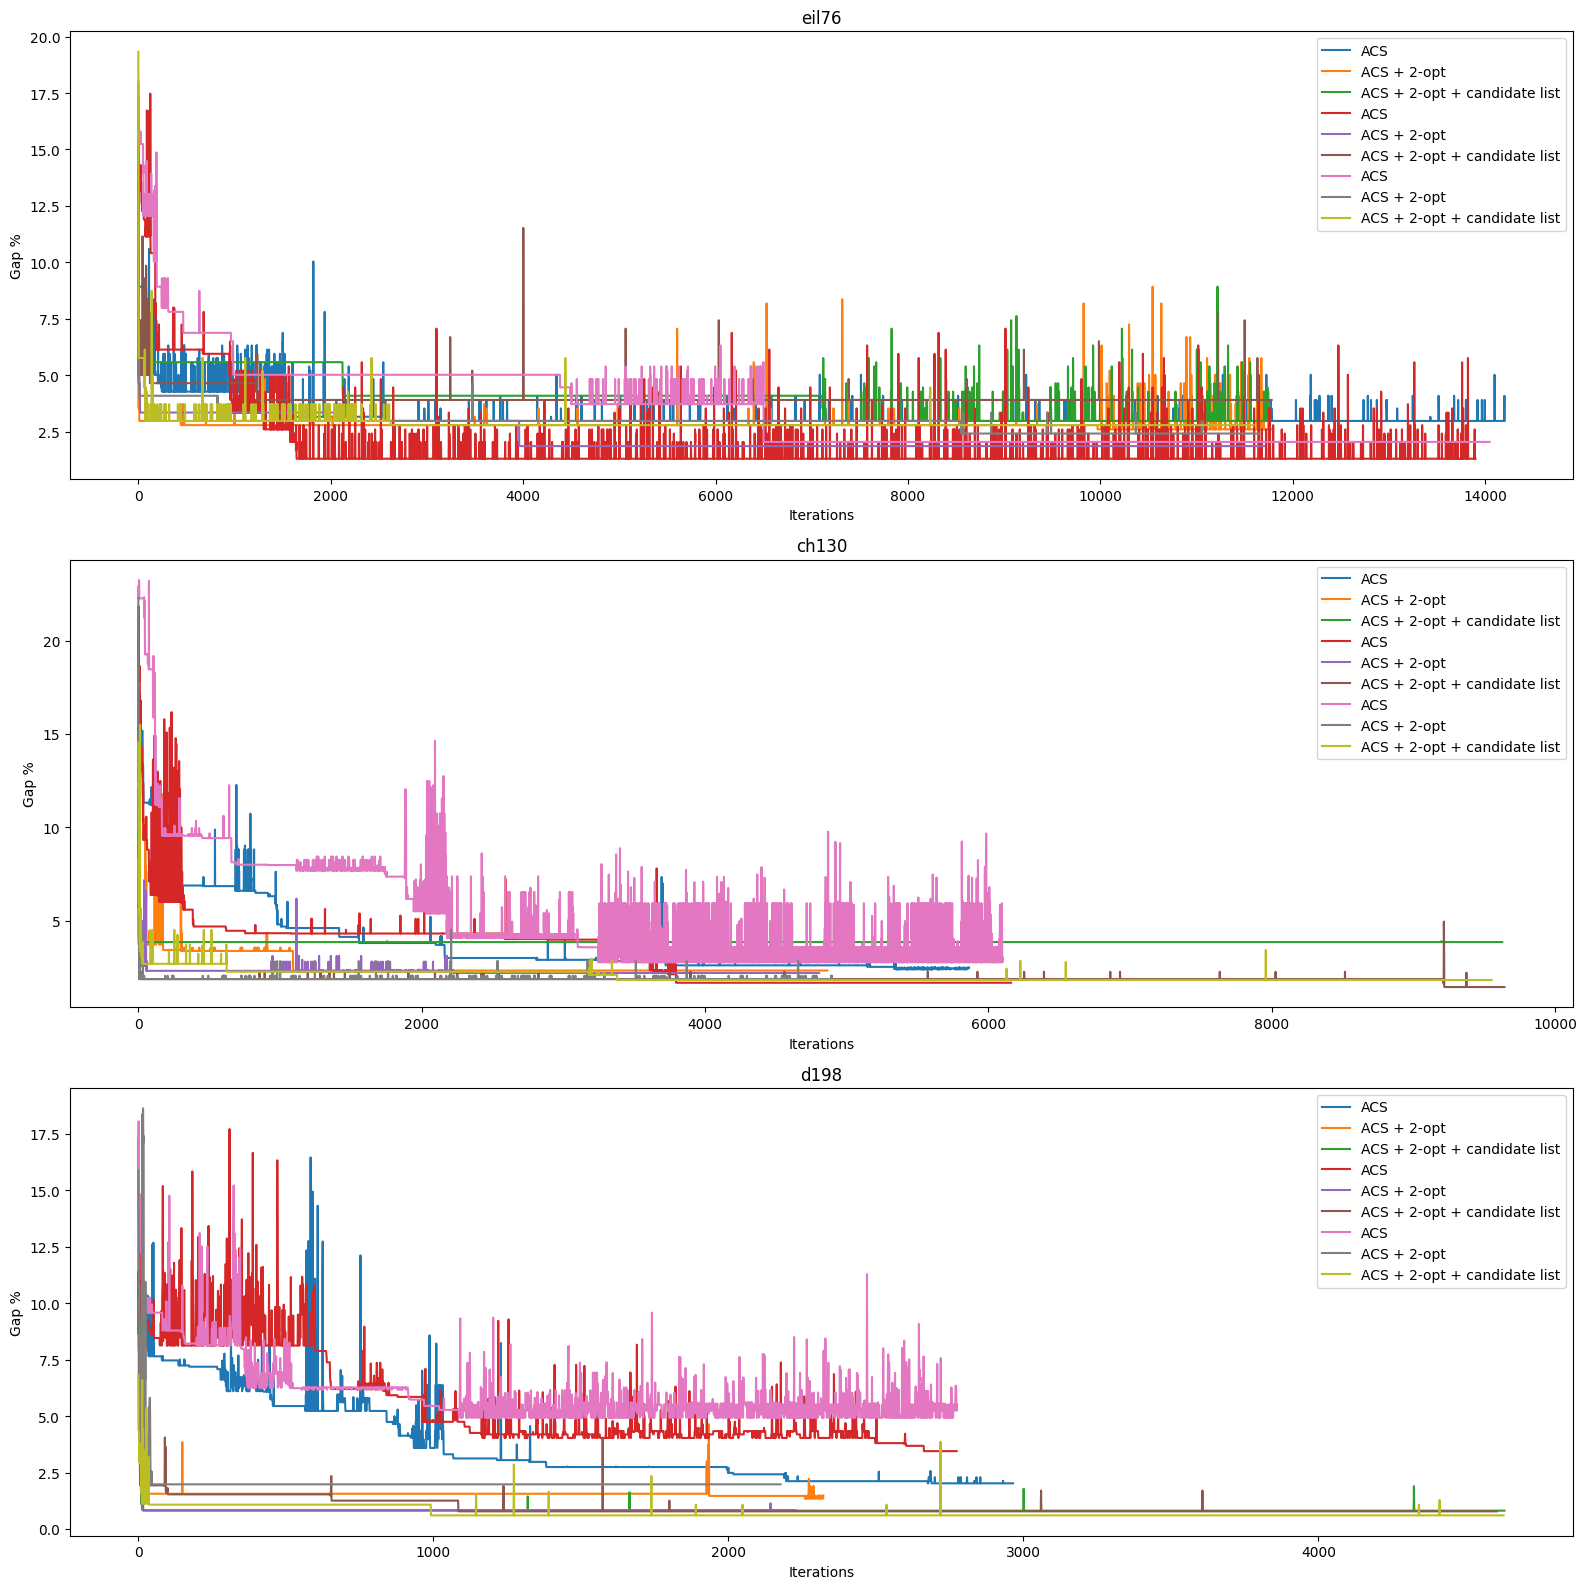

In [30]:
%store -r
import numpy as np
import tabulate
print("Relative errors: ", rel_errors)
print("Relative errors 2opt: ", rel_errors2)
print("Relative errors 2opt + candidate: ", rel_errors3)
print("Best lengths: ", best_lengths)
print("Best lengths 2opt: ", best_lengths2)
print("Best lengths 2opt + candidate: ", best_lengths3)
#print("Optimal solutions: ", opt_solutions)
# Plot the results in one figure

# For each problem instance: A plot showing the average of the three runs and the
# best gap achieved for each run, with the gap on the y-axis and iteration number on
# the x-axis.

# Average of the three runs for each instance
mean_eil76_q1 = []
mean_eil76_q2 = []
mean_eil76_q3 = []
mean_ch130_q1 = []
mean_ch130_q2 = []
mean_ch130_q3 = []
mean_d198_q1 = []
mean_d198_q2 = []

# Mean between basic, 2opt and 2opt + cl
mean_eil76_q1 = np.mean([gaps[0], gaps2[0], gaps3[0]])
mean_eil76_q2 = np.mean([gaps[1], gaps2[1], gaps3[1]])
mean_eil76_q3 = np.mean([gaps[2], gaps2[2], gaps3[2]])
mean_ch130_q1 = np.mean([gaps[3], gaps2[3], gaps3[3]])
mean_ch130_q2 = np.mean([gaps[4], gaps2[4], gaps3[4]])
mean_ch130_q3 = np.mean([gaps[5], gaps2[5], gaps3[5]])
mean_d198_q1 = np.mean([gaps[6], gaps2[6], gaps3[6]])
mean_d198_q2 = np.mean([gaps[7], gaps2[7], gaps3[7]])
mean_d198_q3 = np.mean([gaps[8], gaps2[8], gaps3[8]])

# Mean gap between basic, 2opt and 2opt + cl
plt.plot(mean_eil76_q1, label='AVG GAP, q = 0.98')
# Best gap between basic, 2opt and 2opt + cl
plt.axhline(min(mean_eil76_q1) , label='BEST GAP, q = 0.98', linestyle='--')
plt.plot(mean_eil76_q2, label='AVG GAP, q =0.5')
plt.axhline(min(mean_eil76_q2) , label='BEST GAP, q = 0.5', linestyle='--', color='orange')
plt.plot(mean_eil76_q3, label='AVG GAP, q = 1-13/n')
plt.axhline(min(mean_eil76_q3) , label='BEST GAP, q = 1-13/n', linestyle='--', color='green')
plt.title("eil76")
plt.ylim(0, 10)
plt.legend()
plt.show()

plt.plot(mean_ch130_q1, label='AVG GAP, q = 0.98')
plt.axhline(min(mean_ch130_q1) , label='BEST GAP, q = 0.98', linestyle='--')
plt.plot(mean_ch130_q2, label='AVG GAP, q = 0.5')
plt.axhline(min(mean_ch130_q2) , label='BEST GAP, q = 0.5', linestyle='--', color='orange')
plt.plot(mean_ch130_q3, label='AVG GAP, q = 1-13/n')
plt.axhline(min(mean_ch130_q3) , label='BEST GAP, q = 1-13/n', linestyle='--', color='green')
plt.title("ch130")
plt.ylim(0, 10)
plt.legend()
plt.show()

plt.plot(mean_d198_q1, label='AVG GAP, q = 0.98')
plt.axhline(min(mean_d198_q1) , label='BEST GAP, q = 0.98', linestyle='--')
plt.plot(mean_d198_q2, label='AVG GAP, q = 0.5')
plt.axhline(min(mean_d198_q2) , label='BEST GAP, q = 0.5', linestyle='--', color='orange')
plt.plot(mean_d198_q3, label='AVG GAP, q = 1-13/n')
plt.axhline(min(mean_d198_q3) , label='BEST GAP, q = 1-13/n', linestyle='--', color='green')
plt.title("d198")
plt.ylim(0, 10)
plt.legend()
plt.show()

    
# Plot the averages of the three runs for each instance and the best gap achieved for each run

qs = [0.98, 0.5, 1-13/ic.nPoints]
problems = ['eil76', 'ch130', 'd198']
fig, ax = plt.subplots(3, figsize=(16, 16))
for i, name in enumerate(problems):
    for j,q in enumerate(qs):
        ic = TSP_Instance_Creator("standard", name + '.tsp')
        ax[i].set_title(name)
        ax[i].set_xlabel('Iterations')
        ax[i].set_ylabel('Gap %')
        ax[i].plot(((hist[3*i+j]-np.repeat(ic.best_sol, len(hist[3*i+j])))/ic.best_sol*100), label='ACS')
        ax[i].plot(((hist2opt[3*i+j]-np.repeat(ic.best_sol, len(hist2opt[3*i+j])))/ic.best_sol*100), label='ACS + 2-opt')
        ax[i].plot(((hist3opt[3*i+j]-np.repeat(ic.best_sol, len(hist3opt[3*i+j])))/ic.best_sol*100), label='ACS + 2-opt + candidate list')
        ax[i].plot
        ax[i].legend()
plt.tight_layout()
plt.show()

%store -z